In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Modellek interpretálhatósága

### Korábbi modellek előállítása

In [2]:
odf = pd.read_csv("../data/DataSet_Tesco5000_withDaynum.csv",sep=";")

In [3]:
odf['hetnapja'] = (odf['daynum'] -3 ) % 7

In [4]:
def stat_hozzaado(cust_df,valtozo_neve,aggreg_mode,startnap,endnap,trx_df):
    c1 = trx_df[ trx_df['daynum']>=startnap ]
    c2 = c1[ c1['daynum']<endnap ]
    stat = c2.groupby('customer_id',as_index=False)['visit_spend'].agg(aggreg_mode)
    stat.columns=['customer_id',valtozo_neve]
    
    cust_df = cust_df.merge(stat,on='customer_id',how='left')
    cust_df[valtozo_neve]=cust_df[valtozo_neve].fillna(0)
    return cust_df

In [5]:
def adathalmaz_generalo(iu_nap, df):
    # Celvaltozo legyartasa
    
    celnap1 = df[ df['daynum']>iu_nap ]
    celnap2 = celnap1[ celnap1['daynum']<=iu_nap + 4]
    bejott_userek = pd.DataFrame({ 'customer_id':celnap2['customer_id'].unique() })
    bejott_userek['target']=1
    
    ujdf = pd.DataFrame({ 'customer_id':df['customer_id'].unique() })
    ujdf = ujdf.merge(bejott_userek,on='customer_id',how='left')
    ujdf['target']=ujdf['target'].fillna(0)
    
    # Bemeno valtozok

    # 1. mult heten ugyanekkor hany tranzakcio volt
    ujdf=stat_hozzaado(ujdf,"last_4day_trx_num",
                       'count',iu_nap-6,iu_nap-2,df)
    ujdf=stat_hozzaado(ujdf,"last_4day_trx_sum",
                       'sum',iu_nap-6,iu_nap-2,df)
    
    # 3. mennyit fogyaszt atlagosan egy nap
    ujdf=stat_hozzaado(ujdf,"napi_betevo",
                       'sum',0,iu_nap,df)
    ujdf["napi_betevo"]=ujdf["napi_betevo"]/(iu_nap-1)
    
    # 4. mi a valoszinosege, hogy beter egy adott napon
    ujdf=stat_hozzaado(ujdf,"beteres_p",
                       'count',0,iu_nap,df)
    ujdf["beteres_p"]=ujdf["beteres_p"]/(iu_nap-1)
    
    # 5. elozo 4 heten mi volt a valoszinusege, hogy betert egy adott nap
    for melyik_nap in range(0,7):
        minidf = df[ df['hetnapja']==melyik_nap ]
        ujdf=stat_hozzaado(ujdf,"4w_p_"+str(melyik_nap),
                       'count',iu_nap-28,iu_nap,minidf)
        ujdf["4w_p_"+str(melyik_nap)]=ujdf["4w_p_"+str(melyik_nap)] / 4
    
    # 6. elozo 4 heten mennyit koltott egy atlagos napon
    for melyik_nap in range(0,7):
        minidf = df[ df['hetnapja']==melyik_nap ]
        ujdf=stat_hozzaado(ujdf,"4w_spend_"+str(melyik_nap),
                       'sum',iu_nap-28,iu_nap,minidf)
        ujdf["4w_spend_"+str(melyik_nap)]=ujdf["4w_spend_"+str(melyik_nap)] / 4
        
    # 7. hany napja nem lattuk a boltban, ha meg sohasem lattuk, legyen -1
    df_itt = df[df['daynum']<iu_nap].copy()
    stat = df_itt.groupby('customer_id',as_index=False)['daynum'].agg('max')
    stat.columns=['customer_id','last_visit_day']
    stat['hany_napja_nem_volt']=iu_nap-stat['last_visit_day']
    del stat['last_visit_day']
    ujdf=ujdf.merge(stat,on='customer_id',how='left')
    ujdf['hany_napja_nem_volt']=ujdf['hany_napja_nem_volt'].fillna(-1)
    
    
    return ujdf

elemzesi_df=adathalmaz_generalo(200,odf)

In [6]:
#odf.groupby(['daynum','hetnapja'],as_index=False)['visit_spend'].agg('sum')

In [7]:
kituntetett_datum=429

In [8]:
all_train_df=[]
for i in range(1,10):
    train_df=adathalmaz_generalo(kituntetett_datum-i*7,odf).copy()
    train_df['meta_db_distance']=i
    all_train_df.append(train_df)

train_df=pd.concat(all_train_df)


In [9]:
test_df = adathalmaz_generalo(kituntetett_datum,odf).copy()

In [10]:
#train_df.to_csv('../data/DataSet_Tesco_Prep_d'+str(kituntetett_datum)+"_train.csv",index=False)

In [11]:
#test_df.to_csv('../data/DataSet_Tesco_Prep_d'+str(kituntetett_datum)+"_test.csv",index=False)

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
modell = LogisticRegression()

In [14]:
bemeno_valtozok= list(train_df.columns[2:])

In [15]:
bemeno_valtozok.remove('meta_db_distance')

In [16]:
modell.fit(train_df[bemeno_valtozok],train_df['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
modell.intercept_

array([-1.47684495])

In [18]:
modell.coef_

array([[ 9.75481793e-02, -6.33332944e-04,  3.40600057e-03,
         5.45325919e+00,  5.48656152e-01,  7.94591524e-01,
         8.44790895e-01,  8.33301767e-01, -6.48966361e-02,
        -1.14465454e-01, -8.03234508e-03,  5.26847423e-03,
         8.23742831e-03,  1.16053690e-02,  7.49237551e-03,
        -5.24824194e-03, -5.61297921e-03, -3.54536968e-03,
        -8.25792400e-03]])

In [19]:
bemeno_valtozok

['last_4day_trx_num',
 'last_4day_trx_sum',
 'napi_betevo',
 'beteres_p',
 '4w_p_0',
 '4w_p_1',
 '4w_p_2',
 '4w_p_3',
 '4w_p_4',
 '4w_p_5',
 '4w_p_6',
 '4w_spend_0',
 '4w_spend_1',
 '4w_spend_2',
 '4w_spend_3',
 '4w_spend_4',
 '4w_spend_5',
 '4w_spend_6',
 'hany_napja_nem_volt']

In [20]:
test_df['p0']=0
test_df['p1']=0
test_df[['p0','p1']]=modell.predict_proba(test_df[bemeno_valtozok])

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

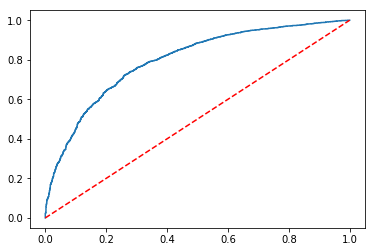

In [22]:
a,b,c = roc_curve(test_df['target'],test_df['p1'])
plt.plot(a,b)
plt.plot([0,1],[0,1],'r--')

In [23]:
roc_auc_score(test_df['target'],test_df['p1'])

0.7970148336946342

# Jol fog meg jonni

In [24]:
from sklearn.datasets import load_digits
digits = load_digits()

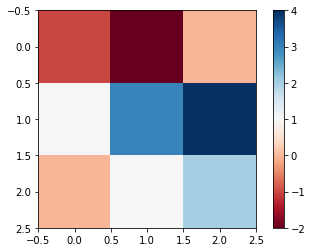

In [25]:
im = plt.imshow(np.reshape([-1,-2,0,1,3,4,0,1,2],(3,3)), cmap=plt.cm.RdBu,interpolation='nearest')
plt.colorbar(im)

## Folytatas innentol

In [29]:
pd.DataFrame({'coef':modell.coef_[0], 'name': bemeno_valtozok})\
.sort_values('coef', ascending=False)

,coef,name
3,5.453259,beteres_p
6,0.844791,4w_p_2
7,0.833302,4w_p_3
5,0.794592,4w_p_1
4,0.548656,4w_p_0
0,0.097548,last_4day_trx_num
13,0.011605,4w_spend_2
12,0.008237,4w_spend_1
14,0.007492,4w_spend_3
11,0.005268,4w_spend_0


In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
modell= GradientBoostingClassifier(n_estimators=100, max_depth=3)
modell=LogisticRegression()
# a második modell az didaktikai utolsó 5 perc, hogy lin regr el így néz ki a GBC hez képest, ez 1 dimenziósan ábrázol,
"""lehet 2D vel is csúszkázni, az lesz a hőtérkép peak under the hood of the black box"""

In [52]:
modell.fit(train_df[bemeno_valtozok], train_df['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
test_df['p1']=modell.predict_proba(test_df[bemeno_valtozok])[:,1]

In [54]:
test_df

,customer_id,target,last_4day_trx_num,last_4day_trx_sum,napi_betevo,beteres_p,4w_p_0,4w_p_1,4w_p_2,4w_p_3,...,4w_spend_0,4w_spend_1,4w_spend_2,4w_spend_3,4w_spend_4,4w_spend_5,4w_spend_6,hany_napja_nem_volt,p0,p1
0,2,1.0,1.0,35.01,5.800841,0.280374,0.00,0.25,0.25,0.00,...,0.0000,8.7525,2.9250,0.0000,0.7825,13.3300,17.9350,5,0.393535,0.606465
1,3,1.0,1.0,78.50,10.393645,0.376168,0.50,0.00,0.25,0.25,...,38.0225,0.0000,0.7450,2.5000,3.9675,0.0000,58.8275,2,0.220552,0.779448
2,4,1.0,0.0,0.00,24.082523,0.224299,0.00,0.00,0.50,0.00,...,0.0000,0.0000,54.6150,0.0000,21.5750,80.2150,40.9400,1,0.484105,0.515895
3,5,1.0,1.0,63.68,9.212991,0.299065,0.25,0.00,0.25,0.50,...,5.4700,0.0000,12.0450,34.2275,0.0000,15.3200,5.0225,3,0.223936,0.776064
4,6,1.0,0.0,0.00,7.977033,0.144860,0.00,0.75,0.00,0.00,...,0.0000,45.7800,0.0000,0.0000,0.0000,17.2050,0.0000,8,0.469517,0.530483
5,7,0.0,1.0,90.05,13.268925,0.116822,0.25,0.50,0.25,0.00,...,73.6625,25.7500,28.4375,0.0000,0.0000,0.0000,50.7400,5,0.332117,0.667883
6,8,1.0,2.0,18.88,12.605631,0.647196,0.75,0.50,0.00,0.50,...,15.2775,9.4475,0.0000,2.8975,11.4150,16.3825,19.7225,1,0.036166,0.963834
7,11,1.0,1.0,20.08,6.567570,0.154206,0.00,0.25,0.25,0.00,...,0.0000,35.1425,5.0200,0.0000,0.0000,0.0000,24.5325,4,0.473313,0.526687
8,12,0.0,0.0,0.00,13.523388,0.320093,0.00,0.50,0.25,0.25,...,0.0000,7.9700,4.0500,16.5125,9.5600,0.0000,61.7750,7,0.268452,0.731548
9,14,1.0,0.0,0.00,6.818271,0.224299,0.00,0.00,0.25,0.00,...,0.0000,0.0000,6.9250,0.0000,13.6150,23.1025,19.9600,7,0.578703,0.421297


In [55]:
roc_auc_score(test_df['target'], test_df['p1'])

0.7970148336946342

last_4day_trx_num


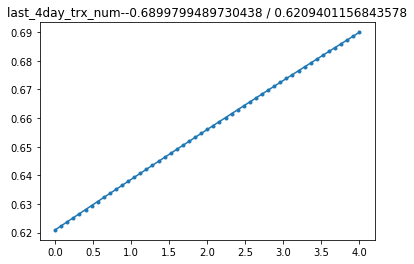

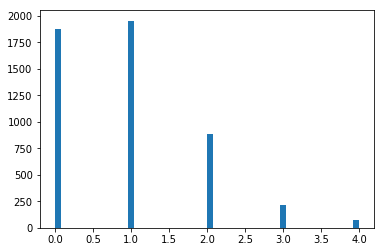

last_4day_trx_sum


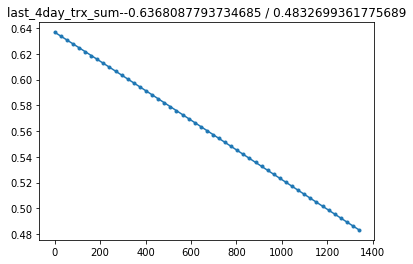

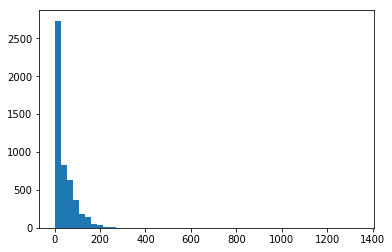

napi_betevo


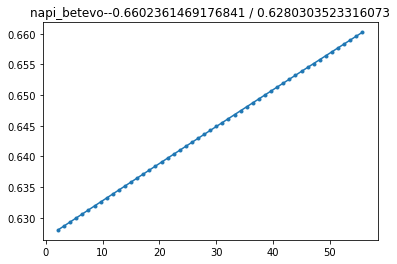

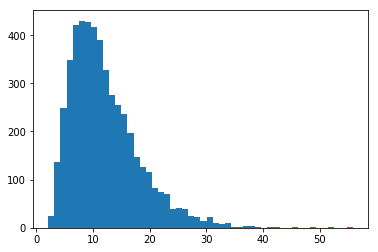

beteres_p


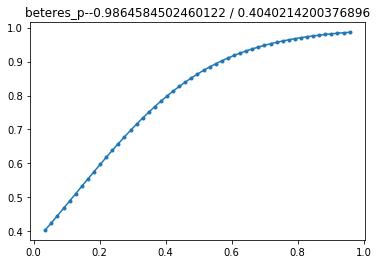

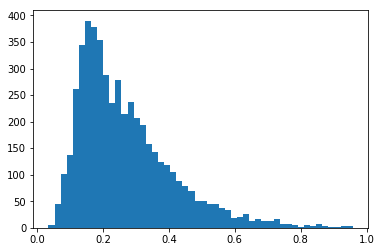

4w_p_0


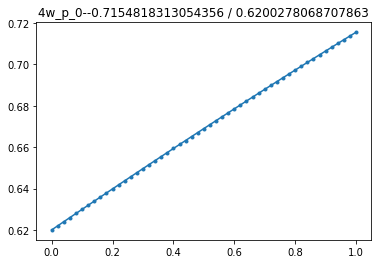

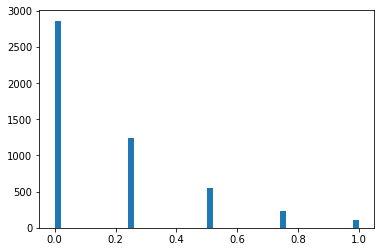

4w_p_1


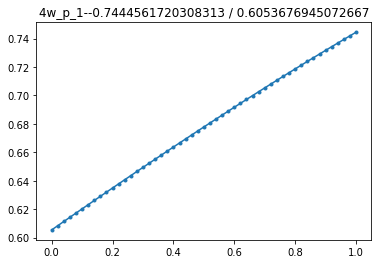

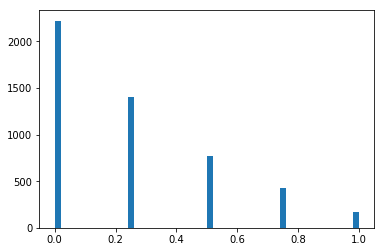

4w_p_2


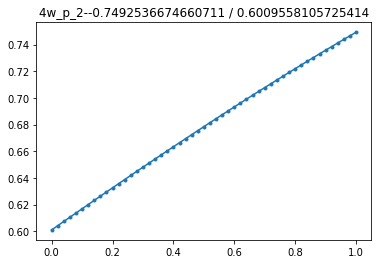

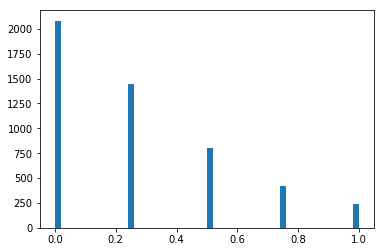

4w_p_3


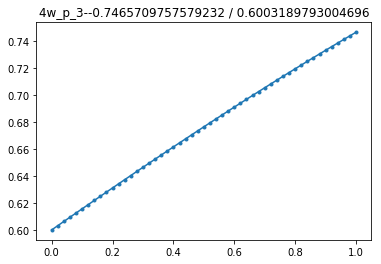

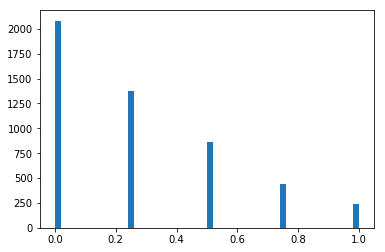

4w_p_4


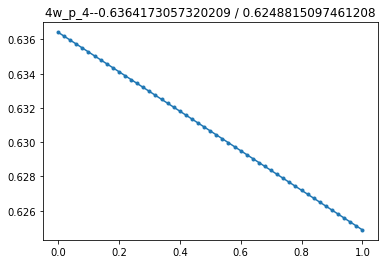

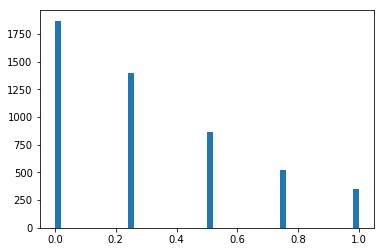

4w_p_5


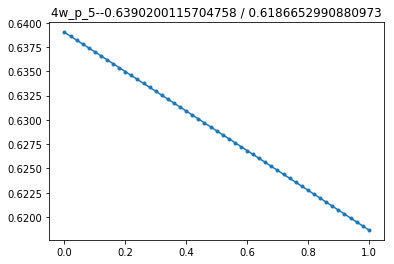

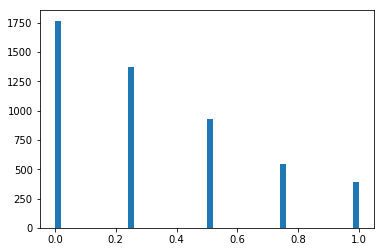

4w_p_6


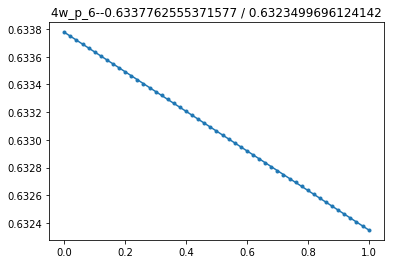

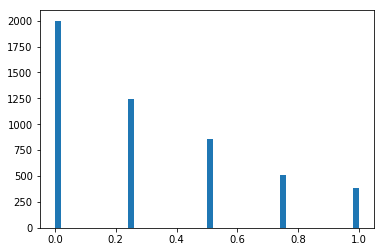

4w_spend_0


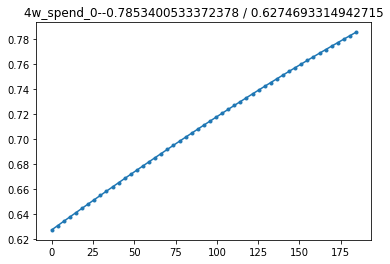

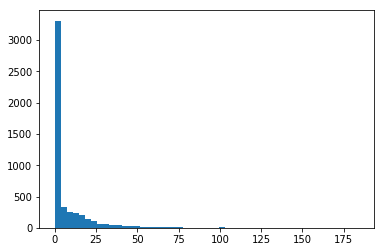

4w_spend_1


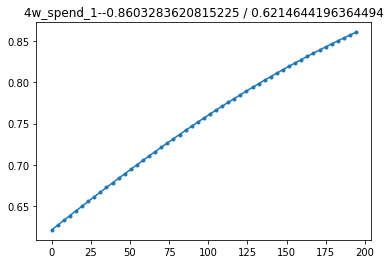

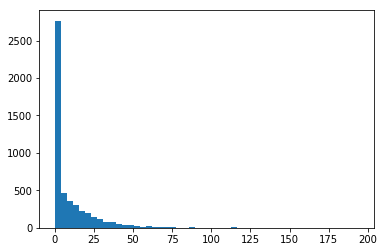

4w_spend_2


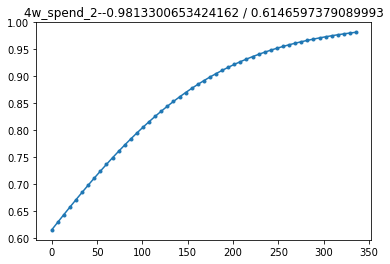

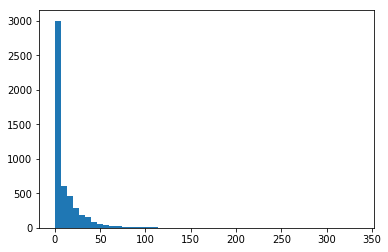

4w_spend_3


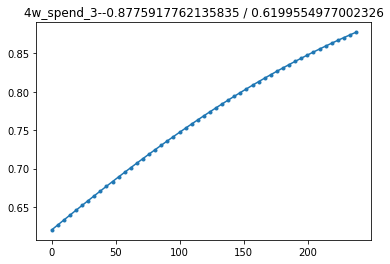

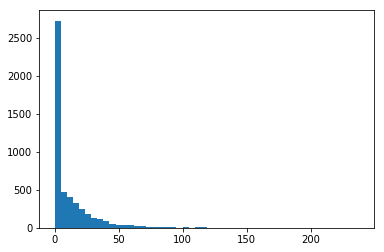

4w_spend_4


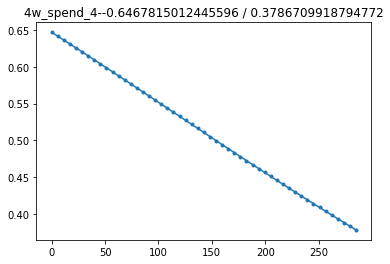

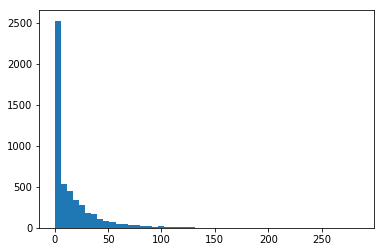

4w_spend_5


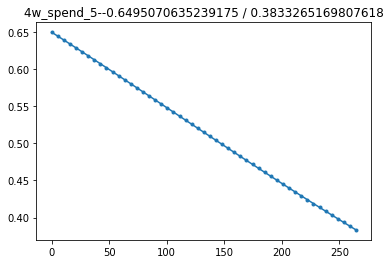

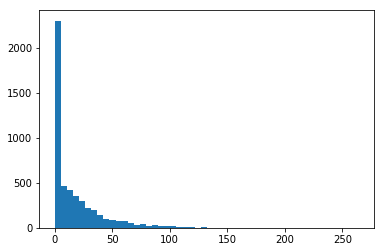

4w_spend_6


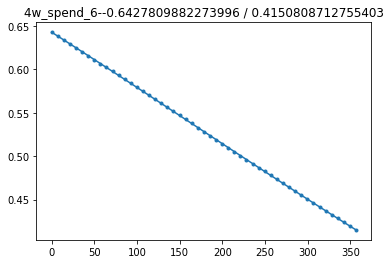

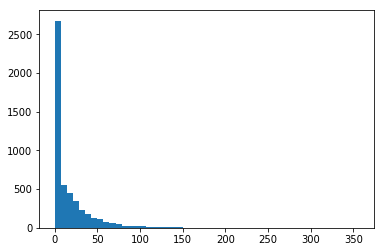

hany_napja_nem_volt


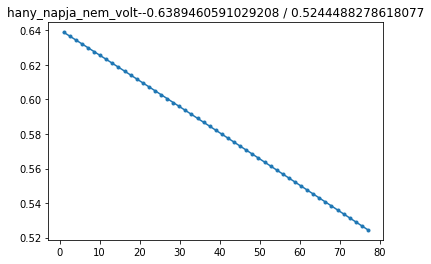

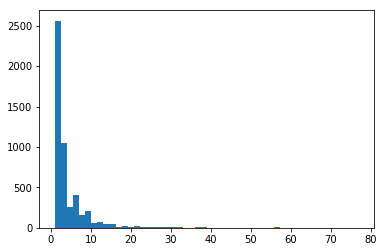

In [56]:
for valtozo_nev in bemeno_valtozok:
    print(valtozo_nev)
    t2=test_df.copy()
    x_tengely=[]
    y_tengely=[]
    
    minx=t2[valtozo_nev].min()
    maxx=t2[valtozo_nev].max()
    lepesszam=50
    lepes=(maxx-minx)/lepesszam
    #for ertek in sorted(test_df[valtozo_nev].unique()):
    for ertek in list(np.arange(minx, maxx,lepes))+[maxx]:
        t2[valtozo_nev]=ertek
        ps=modell.predict_proba(t2[bemeno_valtozok])[:,1]
        avg_pred=np.mean(ps)
        x_tengely.append(ertek)
        y_tengely.append(avg_pred)
    plt.title(valtozo_nev+ "--"+str(np.max(y_tengely))+" / "+ str(np.min(y_tengely)))
    plt.plot(x_tengely, y_tengely,marker='.')
    plt.show()
    plt.hist(test_df[valtozo_nev], bins=lepesszam)
    plt.show()
    #tehát az első változót nem nagyon használta döntési fád
    #ábra 2 ha múlt hét h-csüt 0-t költöttél akkor kicis a valszín h ezen a héten bejösszz h-cs, de vane gy pont ahol jelentős megugrás van\
    #aztán visszaesik szép lassan, tapasztalti tényenzőben ha minden mást ugyanúgy hagysz
    #!!én vmit elszúrtam a plotolásban